In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

import intake
import xesmf as xe

from utils import _convert_lons, _remove_leap_days, _convert_ds_longitude
from regridding import apply_weights

In [2]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [3]:
# pip install xclim

In [4]:
# pip install git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix

In [5]:
write_direc = '/gcs/rhg-data/climate/downscaled/workdir'

In [6]:
# this pulls in sample data which is part of this repo but was taken from scikit-downscale. Includes training data taken from a 50km WRF run over North America and the obs data is sampled from 
# the nearest 1/16th deg grid cell from Livneh et al 2013
from utils import get_sample_data

In [7]:
import xclim
from xclim import sdba
from skdownscale.pointwise_models import PointWiseDownscaler, BcsdTemperature

In [8]:
# training = historical model data, targets = obs data 
training = get_sample_data('training')
targets = get_sample_data('targets')

# define time slices 
train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [9]:
ds_training = training['tmax'][train_slice].to_xarray()
ds_targets = targets['tmax'][train_slice].to_xarray()
ds_predict = training['tmax'][predict_slice].to_xarray()

now start to actually fit models 

In [10]:
bcsd = PointWiseDownscaler(BcsdTemperature(return_anoms=False))

In [11]:
# time grouper --> NASA-NEX method 
bcsd_nasanex = PointWiseDownscaler(BcsdTemperature(return_anoms=False, time_grouper='daily_nasa-nex'))

In [12]:
# actually fitting the model 
bcsd.fit(ds_training, ds_targets)

In [13]:
bcsd_nasanex.fit(ds_training, ds_targets)

In [14]:
# actually predicting using the BCSD model 
bcsd_predicted = bcsd.predict(ds_predict).load()

In [15]:
bcsd_predicted_hist = bcsd.predict(ds_training).load()

In [16]:
bcsd_nasanex_predicted = bcsd_nasanex.predict(ds_predict).load()

In [17]:
# predicting on training data 
bcsd_nasanex_predicted_hist = bcsd_nasanex.predict(ds_training).load()

## now fit QDM model 

In [18]:
# instantiates a grouper class which allows you to group by day of the year 
# window is centered: 31 is the +/-15 day group 
group = sdba.Grouper('time.dayofyear', window=31)

# initiates a qdm model class 
qdm = sdba.adjustment.QuantileDeltaMapping(group=group, kind='+')

In [19]:
qdm

QuantileDeltaMapping(nquantiles=20, kind='+', group=Grouper(dim='time', add_dims=['window'], prop='dayofyear', name='time.dayofyear', window=31, interp=False))

In [20]:
# training QDM model with training and target data 
qdm.train(ds_training, ds_targets)

In [21]:
# predicting using QDM model 
scen = qdm.adjust(ds_predict)

In [26]:
scen_hist = qdm.adjust(ds_training)

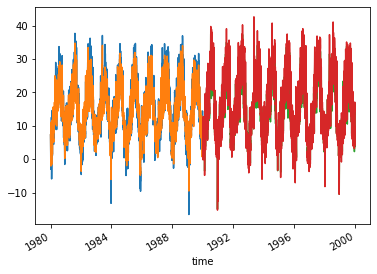

In [22]:
ds_training.plot()
ds_targets.plot()
ds_predict.plot()
scen.plot()

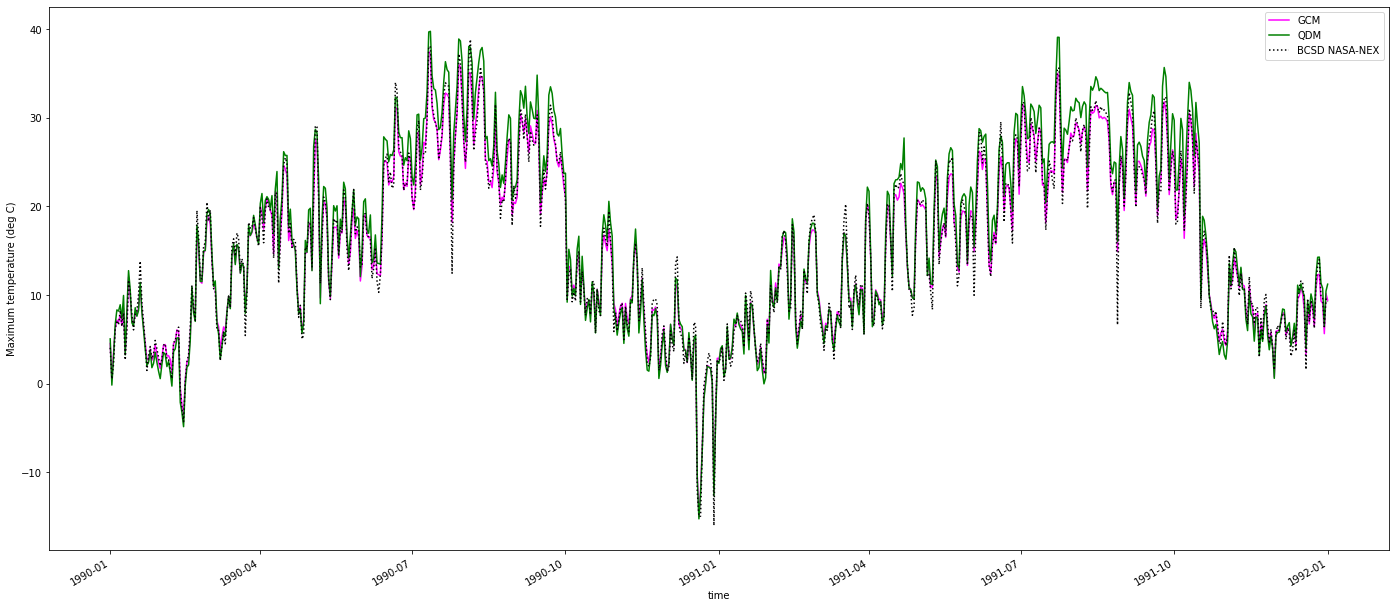

In [23]:
plt.figure(figsize=(24, 10))
start = "1990-01-01"
end = "1992-01-01"
ds_predict.sel(time=slice(start, end)).plot(color='magenta', linestyle="-", label='GCM')

scen.sel(time=slice(start, end)).plot(color='green', label='QDM')

# bcsd_predicted.sel(time=slice(start, end)).plot(color='blue', label='BCSD')

bcsd_nasanex_predicted.sel(time=slice(start, end)).plot(color='black', linestyle=":", label='BCSD NASA-NEX')
plt.legend()
plt.ylabel('Maximum temperature (deg C)')
plt.savefig(os.path.join(write_direc, 'tmax_predict_qdm.png'), bbox_inches='tight')

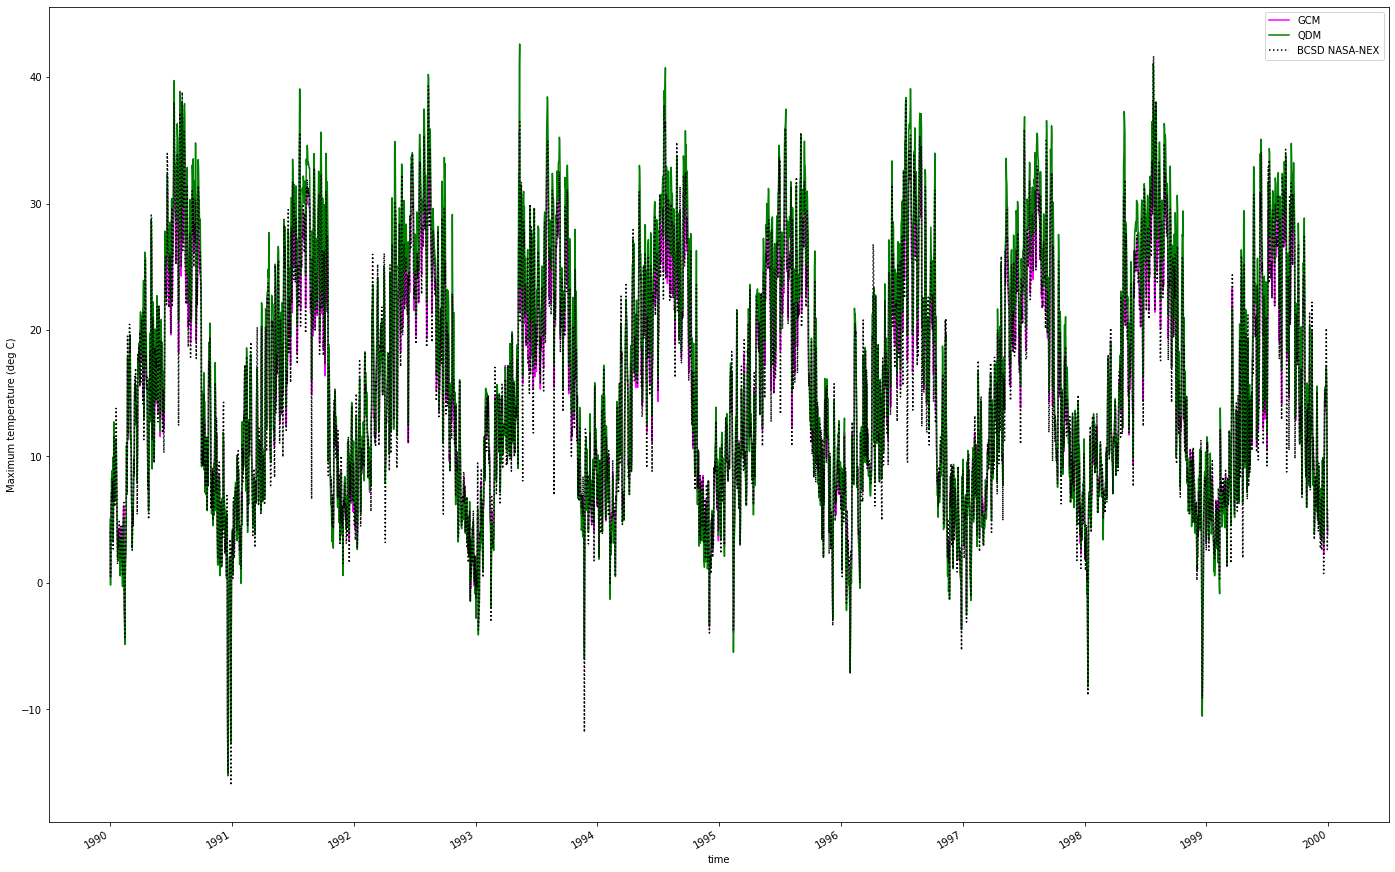

In [24]:
plt.figure(figsize=(24, 15))
start = "1990-01-01"
end = "1992-01-01"
ds_predict.plot(color='magenta', linestyle="-", label='GCM')

scen.plot(color='green', label='QDM')

# bcsd_predicted.sel(time=slice(start, end)).plot(color='blue', label='BCSD')

bcsd_nasanex_predicted.plot(color='black', linestyle=":", label='BCSD NASA-NEX')
plt.legend()
plt.ylabel('Maximum temperature (deg C)')
plt.savefig(os.path.join(write_direc, 'tmax_predict_qdm_fullts.png'), bbox_inches='tight')

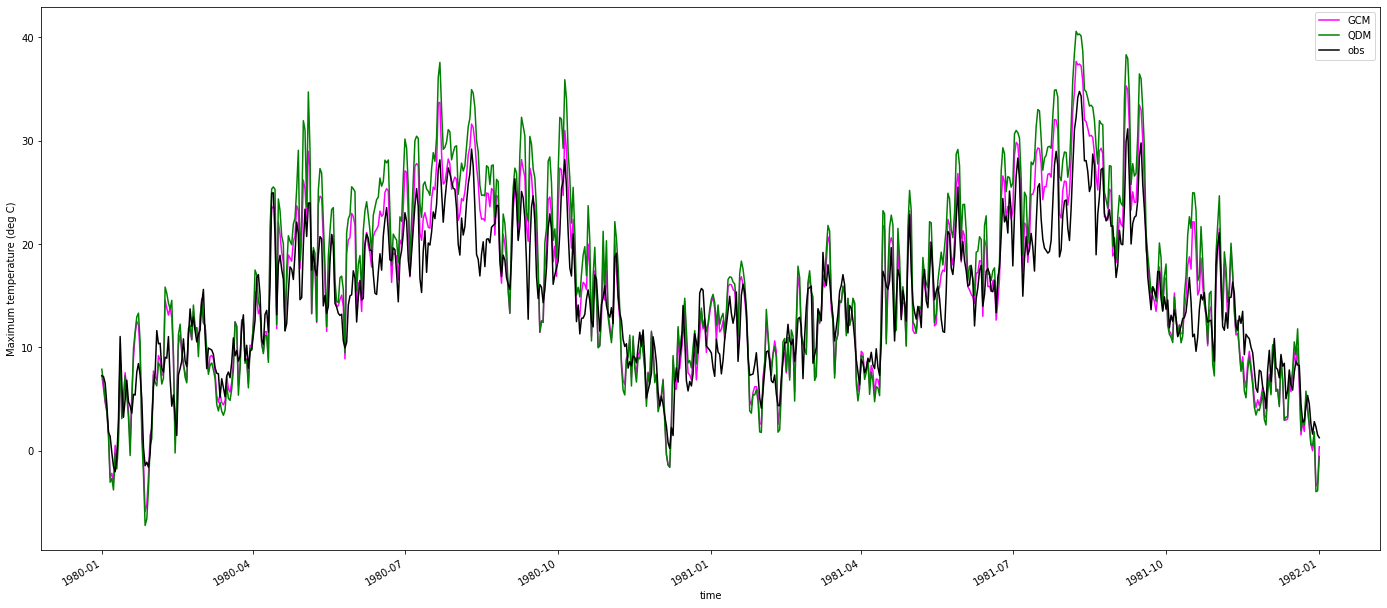

In [27]:
plt.figure(figsize=(24, 10))
start = "1980-01-01"
end = "1982-01-01"
ds_training.sel(time=slice(start, end)).plot(color='magenta', label='GCM')
scen_hist.sel(time=slice(start, end)).plot(color='green', label='QDM')

# bcsd_predicted_hist.sel(time=slice(start, end)).plot(color='blue', label='BCSD')

# bcsd_nasanex_predicted_hist.sel(time=slice(start, end)).plot(color='lightblue', label='BCSD NASA-NEX')

ds_targets.sel(time=slice(start, end)).plot(color='black', label='obs')
plt.legend()
plt.ylabel('Maximum temperature (deg C)')

plt.savefig(os.path.join(write_direc, 'tmax_training_qdm.png'), bbox_inches='tight')

now test with some CMIP6 data and using GMFD as stand-in for ERA-5

In [28]:
client, cluster = rhgk.get_cluster(
    extra_pip_packages="git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix")

# client, cluster = rhgk.get_cluster(name='gcr.io/rhg-project-1/worker:v1.0.0')

In [29]:
cluster

In [30]:
train_slice = slice('1980', '1989')  # train time range
holdout_slice = slice('1990', '2000')  # prediction time range

In [31]:
# use GMFD as standin for ERA-5
tmax_obs = xr.open_mfdataset(os.path.join('/gcs/rhg-data/climate/source_data/GMFD/tmax', 
                                         'tmax_0p25_daily_198*'), concat_dim='time', combine='nested',
                              parallel=True).squeeze(drop=True).rename({'latitude': 'lat', 'longitude': 'lon'})

# standardize longitudes 
tmax_obs =  _convert_ds_longitude(tmax_obs, lon_name='lon')

# remove leap days 
tmax_obs = _remove_leap_days(tmax_obs)

obs_subset = tmax_obs.sel(time=train_slice)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [32]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp370'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

/home/jovyan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask(
           ).isel(member_id=0).squeeze(drop=True).drop(['height', 'member_id'])


ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

regrid obs to model resolution 

In [34]:
# first rechunk in space for xESMF 
chunks = {'lat': len(obs_subset.lat), 'lon': len(obs_subset.lon), 'time': 100}
obs_subset = obs_subset.chunk(chunks)

In [35]:
%%time
obs_to_mod_weights = os.path.join(write_direc, 'bias_correction_bilinear_weights_new.nc')

regridder_obs_to_mod = xe.Regridder(obs_subset.isel(time=0, drop=True), 
                                    ds_model.isel(time=0, drop=True), 
                                    'bilinear', 
                                    filename=obs_to_mod_weights, 
                                    reuse_weights=True)

obs_subset_modres_lazy = xr.map_blocks(apply_weights, regridder_obs_to_mod, 
                                args=[tmax_obs['tmax']])

obs_subset_modres = obs_subset_modres_lazy.compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 608 ms, sys: 593 ms, total: 1.2 s
Wall time: 34.1 s


### subset datasets to get ready for bias correcting 

In [36]:
chunks = {'lat': 10, 'lon': 10, 'time': -1}

train_subset = ds_model['tasmax'].sel(time=train_slice)
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


holdout_subset = ds_model['tasmax'].sel(time=holdout_slice)
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

<ipython-input-36-6288eee6ee8f>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
<ipython-input-36-6288eee6ee8f>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()


In [44]:
obs_subset_fortraining = obs_subset_modres.chunk(chunks)

actually fit and train the model 

In [37]:
group = sdba.Grouper('time.dayofyear', window=31)
qdm = sdba.adjustment.QuantileDeltaMapping(group=group, kind='+')

In [45]:
qdm_trained = qdm.train(train_subset, obs_subset_fortraining)

In [46]:
qdm_predict = qdm.adjust(holdout_subset)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


In [48]:
qdm_predicted = qdm_predict.load()

In [50]:
qdm_predicted.to_netcdf(os.path.join(write_direc, 'test_qdm.nc'))

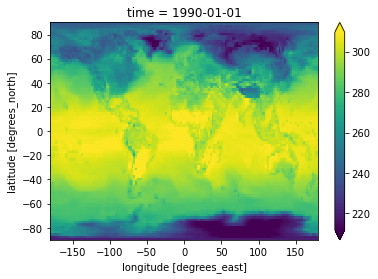

In [53]:
qdm_predicted.isel(time=0).plot(robust=True)